In [1]:
import numpy as np
import matplotlib.pylab as plt

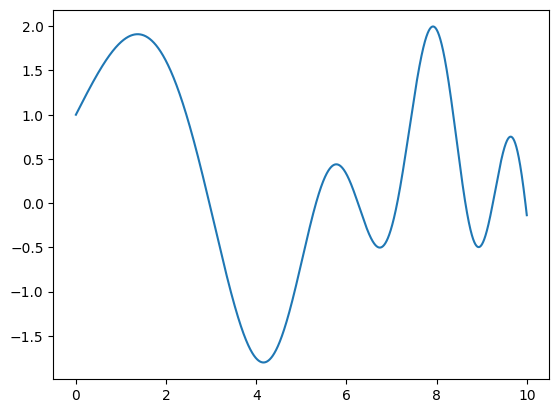

In [2]:
import random
random.seed(42)

xs = np.linspace(0, 10, 10000)
ys = np.sin(xs) + np.cos(0.2* xs**2)
# for i in range(0, 10000, 100):
#     ys[i] += random.random() - 0.5

plt.plot(xs, ys);

In [8]:
from sklearn.tree import DecisionTreeRegressor

pred_sofar = np.zeros_like(ys)
X = xs.reshape(-1, 1)

def update(pred_sofar):
    plt.figure(figsize=(12, 3))
    plt.subplot(131)
    plt.plot(xs, ys, label="orig")
    plt.plot(xs, pred_sofar, label="pred")
    plt.legend()

    err_sofar = pred_sofar - ys
    
    plt.subplot(132)
    plt.ylim(ys.min() - 0.3, ys.max())
    plt.plot(xs, err_sofar)
    plt.title("error sofar")
    
    new_model = DecisionTreeRegressor(max_depth=3)
    new_model.fit(X, ys - pred_sofar)
    new_preds = new_model.predict(X)
    pred_sofar += new_preds * 0.5

    plt.subplot(133)
    plt.plot(xs, new_preds)
    plt.ylim(ys.min() - 0.3, ys.max())
    plt.title("local correction")
    return pred_sofar


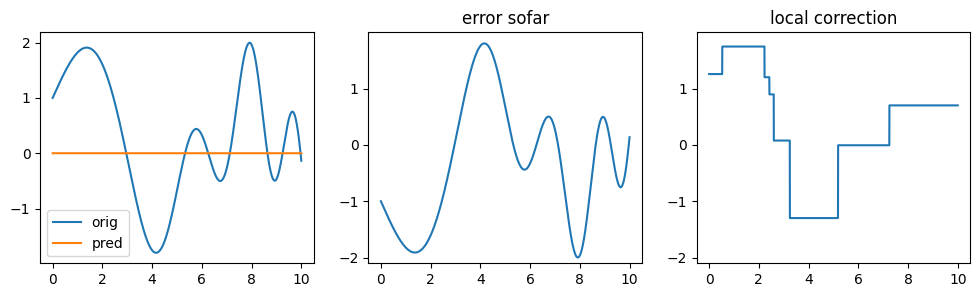

In [9]:
pred_sofar = update(pred_sofar)

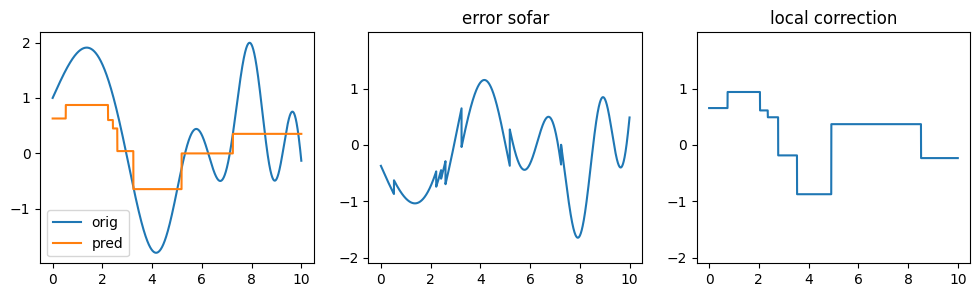

In [10]:
pred_sofar = update(pred_sofar)

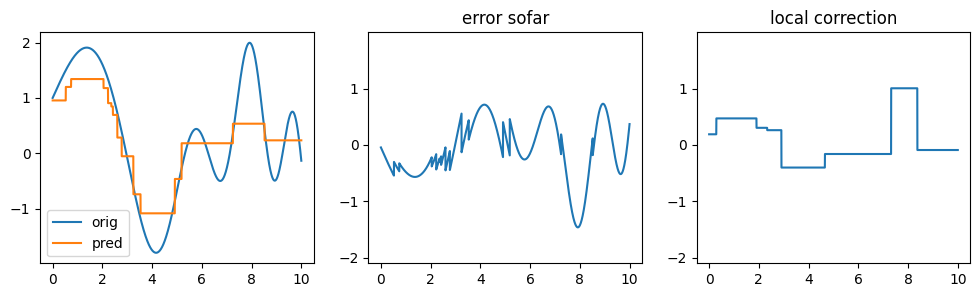

In [11]:
pred_sofar = update(pred_sofar)

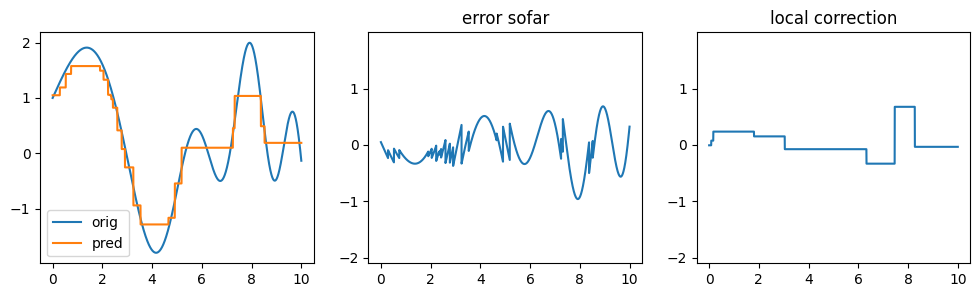

In [12]:
pred_sofar = update(pred_sofar)

In [8]:
from ipywidgets import interact

@interact(split=(xs.min()+0.001, xs.max(), 0.01))
def f(split):
    plt.figure(figsize=(12, 3))
    plt.plot(xs, ys, label="orig")
    plt.axvline(split, color="black", linestyle="--")
    pred = np.where(xs < split, ys[xs < split].mean(), ys[xs >= split].mean())
    plt.plot(xs, pred, label="pred")
    plt.legend()
    plt.title(f"err = {np.mean((pred - ys)**2)}")


interactive(children=(FloatSlider(value=4.9910000000000005, description='split', max=10.0, min=0.001, step=0.0…

In [9]:
def sliding(arr):
    for i, val in enumerate(arr):
        if i != len(arr) - 1:
            yield arr[i], arr[i+1]
        

In order for the below cells to run, you're gonna want to run the 2nd cell first. It's annoying, I know, but it's a better layout this way.

In [15]:
import ipywidgets

cuts = []
btn = ipywidgets.Button(description="make the cut")

def onclick(event):
    cuts.append(f.widget.children[0].value)

btn.on_click(onclick)

btn

Button(description='make the cut', style=ButtonStyle())

In [16]:
@interact(p=(xs.min()+0.001, xs.max(), 0.01))
def f(p):
    global cuts
    plt.figure(figsize=(12, 3))
    plt.plot(xs, ys, label="orig")
    plt.axvline(p, color="black", linestyle="--")
    cuts_new = sorted([0] + [p] + cuts)
    pred = np.zeros_like(ys)
    for lower, upper in sliding(cuts_new):
        x_lower = np.argmin((xs - lower) ** 2)
        x_upper = np.argmin((xs - upper) ** 2)
        pred[x_lower:x_upper] = ys[x_lower:x_upper].mean()
    plt.plot(xs, pred, label="pred")
    plt.legend()
    plt.title(f"err = {np.mean((pred - ys)**2)}")

interactive(children=(FloatSlider(value=4.9910000000000005, description='p', max=10.0, min=0.001, step=0.01), …

In [73]:
import time 
import tqdm
from sklearn.datasets import make_classification
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

results = []

for size in tqdm.tqdm([500, 1_000, 5_000, 10_000, 20_000, 50_000]):
    X, y = make_classification(random_state=42, n_samples=size)
    for method in [HistGradientBoostingRegressor, GradientBoostingRegressor]:
        tic = time.time()
        score = cross_val_score(method(), X=X, y=y, n_jobs=-1).mean()
        toc = time.time()
        results.append({
            "size": size,
            "method": method().__class__.__name__,
            "score": score,
            "time": toc - tic
        })

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:52<00:00,  8.70s/it]


In [74]:
import altair as alt 
import polars as pl

p1 = (alt.Chart(pl.DataFrame(results))
  .mark_line()
  .ecnode(x=alt.X('size').scale(type="log"), y='time', color="method")
  .properties(width=600, height=150))

p2 = (alt.Chart(pl.DataFrame(results))
  .mark_line()
  .encode(x=alt.X('size').scale(type="log"), y='score', color="method")
  .properties(width=600, height=150))

(p1 & p2).interactive()

alt.VConcatChart(...)

In [10]:
!wget https://calmcode.io/static/data/smoking.csv

--2024-05-22 15:55:41--  https://calmcode.io/static/data/smoking.csv
Resolving calmcode.io (calmcode.io)... 172.66.0.96, 162.159.140.98
Connecting to calmcode.io (calmcode.io)|172.66.0.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16000 (16K) [application/octet-stream]
Saving to: ‘smoking.csv.1’

smoking.csv.1       100%[===================>]  15.62K  --.-KB/s    in 0s      

2024-05-22 15:55:41 (68.4 MB/s) - ‘smoking.csv.1’ saved [16000/16000]



In [1]:
import polars as pl

df = pl.read_csv("smoking.csv")

In [2]:
(
    df
    .with_columns(alive=pl.col('outcome') == 'Alive')
    .group_by('smoker')
    .mean()
    .select('smoker', 'alive')
)

smoker,alive
str,f64
"""Yes""",0.761168
"""No""",0.685792


In [5]:
(
    df
    .with_columns(alive=pl.col('outcome') == 'Alive', age_bucket=(pl.col('age') // 5) * 5)
    .group_by('smoker', 'age_bucket')
    .mean()
    .select('smoker', 'age_bucket', 'alive')
    .sort('smoker', 'age_bucket')
    .pivot('alive',  'age_bucket', 'smoker', aggregate_function='mean')
).plot(x='age_bucket')

:NdOverlay   [Variable]
   :Curve   [age_bucket]   (value)

In [9]:
y = df['outcome'].to_list()
X = df.select('age', 'smoker').to_pandas()

In [11]:
ColumnTransformer([
    ('smoke', OneHotEncoder(), ['smoker']),
    ('age', FunctionTransformer(), ['age'])
]).fit_transform(X)

array([[ 0.,  1., 23.],
       [ 0.,  1., 18.],
       [ 0.,  1., 71.],
       ...,
       [ 0.,  1., 21.],
       [ 1.,  0., 46.],
       [ 0.,  1., 41.]])

In [16]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

pipe = make_pipeline(
    ColumnTransformer([
        ('smoke', OneHotEncoder(), ['smoker']),
        ('age', FunctionTransformer(), ['age'])
    ]),
    HistGradientBoostingClassifier(monotonic_cst=[0, 0, 1])
) 

probas = pipe.fit(X, y).predict_proba(X)

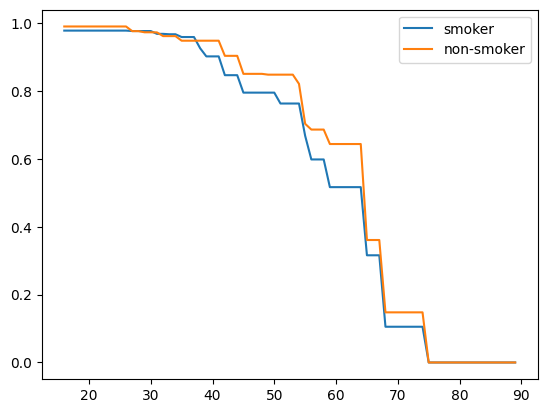

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

age = np.arange(16, 90)

df_smoke = pd.DataFrame({'age':age, 'smoker': ['Yes' for _ in age]})
df_non_smoke = pd.DataFrame({'age':age, 'smoker': ['No' for _ in age]})

plt.plot(age, pipe.predict_proba(df_smoke)[:, 0], label='smoker')
plt.plot(age, pipe.predict_proba(df_non_smoke)[:, 0], label='non-smoker')
plt.legend()

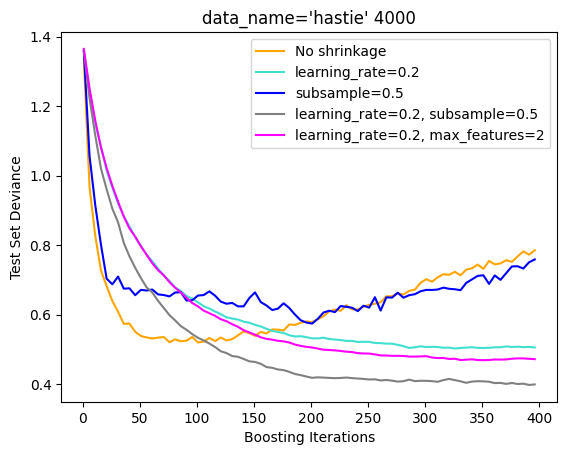

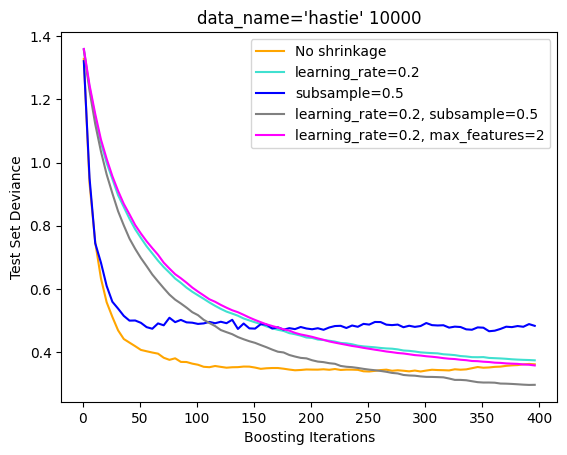

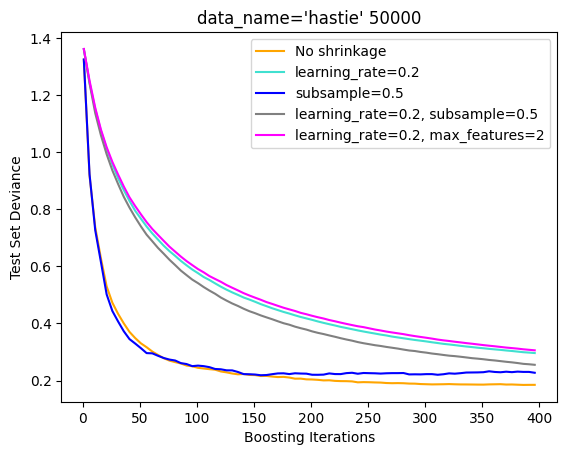

In [13]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, ensemble
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

def simulate(data_name, n_samples):
    fetcher_lookup = {
        'hastie': datasets.make_hastie_10_2,
        'blobs': datasets.make_blobs,
    }
    X, y = fetcher_lookup[data_name](n_samples=n_samples, random_state=1)
    
    # map labels from {-1, 1} to {0, 1}
    labels, y = np.unique(y, return_inverse=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)
    
    original_params = {
        "n_estimators": 400,
        "max_leaf_nodes": 4,
        "max_depth": None,
        "random_state": 2,
        "min_samples_split": 5,
    }
    
    plt.figure()
    
    for label, color, setting in [
        ("No shrinkage", "orange", {"learning_rate": 1.0, "subsample": 1.0}),
        ("learning_rate=0.2", "turquoise", {"learning_rate": 0.2, "subsample": 1.0}),
        ("subsample=0.5", "blue", {"learning_rate": 1.0, "subsample": 0.5}),
        (
            "learning_rate=0.2, subsample=0.5",
            "gray",
            {"learning_rate": 0.2, "subsample": 0.5},
        ),
        (
            "learning_rate=0.2, max_features=2",
            "magenta",
            {"learning_rate": 0.2, "max_features": 2},
        ),
    ]:
        params = dict(original_params)
        params.update(setting)
    
        clf = ensemble.GradientBoostingClassifier(**params)
        clf.fit(X_train, y_train)
    
        # compute test set deviance
        test_deviance = np.zeros((params["n_estimators"],), dtype=np.float64)
    
        for i, y_proba in enumerate(clf.staged_predict_proba(X_test)):
            test_deviance[i] = 2 * log_loss(y_test, y_proba[:, 1])
    
        plt.plot(
            (np.arange(test_deviance.shape[0]) + 1)[::5],
            test_deviance[::5],
            "-",
            color=color,
            label=label,
        )
    
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Test Set Deviance")
    plt.title(f"{data_name=} {n_samples}")
    plt.show()



simulate('hastie', 4000)
simulate('hastie', 10000)
simulate('hastie', 50000)

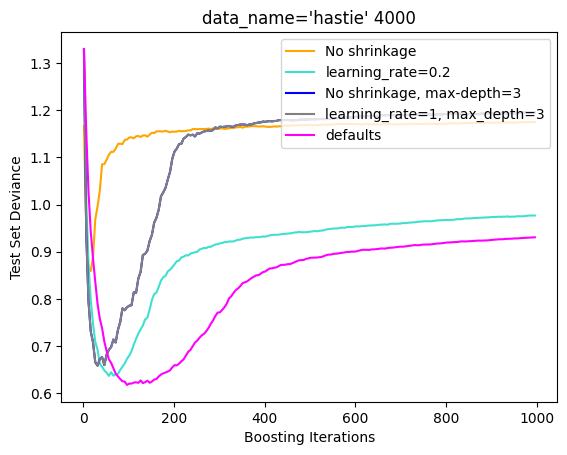

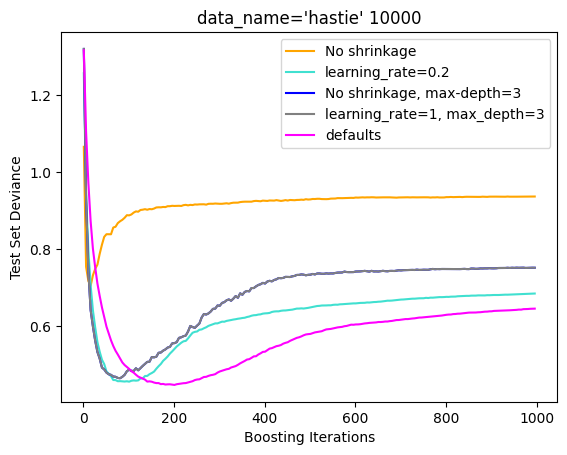

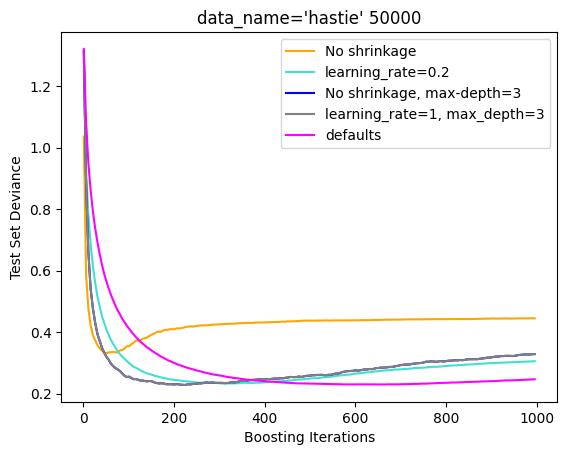

In [7]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, ensemble
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

def simulate(data_name, n_samples):
    fetcher_lookup = {
        'hastie': datasets.make_hastie_10_2,
        'blobs': datasets.make_blobs,
    }
    X, y = fetcher_lookup[data_name](n_samples=n_samples, random_state=1)
    
    # map labels from {-1, 1} to {0, 1}
    labels, y = np.unique(y, return_inverse=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)
    
    plt.figure()
    
    for label, color, setting in [
        ("No shrinkage", "orange", {"learning_rate": 1.0}),
        ("learning_rate=0.2", "turquoise", {"learning_rate": 0.2}),
        ("No shrinkage, max-depth=3", "blue", {"learning_rate": 1.0, "max_depth": 3}),
        (
            "learning_rate=1, max_depth=3",
            "gray",
            {"learning_rate": 1.0, "max_depth": 3},
        ),
        (
            "defaults",
            "magenta",
            {},
        ),
    ]:
        params = dict(max_iter=1_000)
        params.update(setting)
    
        clf = ensemble.HistGradientBoostingClassifier(**params)
        clf.fit(X_train, y_train)
    
        # compute test set deviance
        test_deviance = np.zeros((clf.n_iter_,), dtype=np.float64)
    
        for i, y_proba in enumerate(clf.staged_predict_proba(X_test)):
            test_deviance[i] = 2 * log_loss(y_test, y_proba[:, 1])
    
        plt.plot(
            (np.arange(test_deviance.shape[0]) + 1)[::5],
            test_deviance[::5],
            "-",
            color=color,
            label=label,
        )
    
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Test Set Deviance")
    plt.title(f"{data_name=} {n_samples}")
    plt.show()



simulate('hastie', 4000)
simulate('hastie', 10000)
simulate('hastie', 50000)

In [8]:
import numpy as np
from sklearn.datasets import make_classification

rng = np.random.RandomState(42)

def add_missing_values(X_full, y_full):
    n_samples, n_features = X_full.shape

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[:n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan
    y_missing = y_full.copy()

    return X_missing, y_missing

X, y = add_missing_values(*make_classification(n_samples=10000, n_clusters_per_class=4, n_informative=5, random_state=42))

In [12]:
X.shape

(10000, 20)

In [9]:
np.isnan(X).sum()

7500

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(
    SimpleImputer(),
    LogisticRegression()
)

cross_validate(pipe, X, y)

{'fit_time': array([0.13124895, 0.01602197, 0.09071779, 0.02767015, 0.01983714]),
 'score_time': array([0.00165701, 0.00338197, 0.00081706, 0.00271797, 0.00063801]),
 'test_score': array([0.748 , 0.7485, 0.7515, 0.7415, 0.767 ])}

In [14]:
pipe = make_pipeline(
    HistGradientBoostingClassifier()
)

cross_validate(pipe, X, y)

{'fit_time': array([1.11932611, 1.02378583, 1.12866306, 1.0232687 , 1.07023382]),
 'score_time': array([0.00822186, 0.00749707, 0.00855803, 0.0074842 , 0.00739503]),
 'test_score': array([0.834 , 0.8555, 0.8515, 0.8705, 0.8725])}